# Predicting Analyst Consensus Notebook 3

# Modeling Notebook

In [82]:
# General Packages
import pandas as pd
import yfinance as yf
import numpy as np
import seaborn as sns
from yahooquery import Ticker
from tqdm import tqdm
import matplotlib.pyplot as plt

# SK-Learn Packages
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression

# CNN Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical
from keras.metrics import Precision, Recall, AUC
from keras import backend as K

## The Business Problem

##### We've been tasked by (ficticious) hedge fund Frye Street Capital to gauge the impact of fundamental financial data on a stock's value. 

## Data Preparation and Understanding- See Notebooks 1 and 2

In [83]:
# Reading in most recent data
stock_data = pd.read_csv('data/CompletedData.csv')
stock_data.drop(['Unnamed: 0'], axis = 1, inplace = True)
stock_data.dropna(inplace = True)

In [84]:
stock_data.describe()

,AveragePriceTarget,NumRatings,ClosingPrice,MarketCap,ExpectedGrowthRate,OverallRecommendation,ProjectedMarketCap,TotalRevenue,NormEBITDA,ReturnOnAssets,ChangeNormEBITDA,ChangeRevenue,OperatingCashFlow,ChangeOCF
count,1945.000000,1945.000000,1945.000000,1.945000e+03,1945.000000,1945.000000,1.945000e+03,1.945000e+03,1.945000e+03,1945.000000,1.945000e+03,1.945000e+03,1.945000e+03,1.945000e+03
mean,74.216329,9.573265,62.437311,9.412715e+09,0.392974,0.788175,1.099520e+10,4.109402e+09,7.962129e+08,-0.020698,3.504065e+07,4.854726e+08,5.613016e+08,2.675059e+06
std,140.557936,4.691940,128.272359,1.850647e+10,0.413331,0.408707,2.066704e+10,7.251109e+09,1.481109e+09,0.182612,1.406330e+08,1.030938e+09,1.067708e+09,1.025702e+08
min,0.600000,4.000000,0.390000,2.959104e+07,-0.151000,0.000000,4.259801e+07,0.000000e+00,-9.360000e+08,-1.000000,-4.180000e+08,-1.514000e+09,-5.137450e+08,-1.710000e+09
25%,15.500000,6.000000,10.730000,9.377692e+08,0.121000,1.000000,1.405625e+09,3.480850e+08,-1.026871e+07,-0.043340,0.000000e+00,1.528700e+07,-8.415000e+06,0.000000e+00
50%,36.580000,8.000000,28.310000,2.818498e+09,0.256000,1.000000,3.642117e+09,1.356660e+09,2.406280e+08,0.027930,0.000000e+00,1.302310e+08,1.683100e+08,0.000000e+00
75%,85.000000,13.000000,71.190000,8.396930e+09,0.510000,1.000000,1.015952e+10,4.581100e+09,9.306570e+08,0.065240,9.199000e+06,5.360000e+08,6.257270e+08,0.000000e+00
max,2800.000000,20.000000,2615.600000,1.972006e+11,1.991000,1.000000,2.271751e+11,1.091200e+11,1.257500e+10,0.238460,1.309928e+09,8.335000e+09,7.762000e+09,2.518713e+09


In [85]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1945 entries, 0 to 1944
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Ticker                 1945 non-null   object 
 1   AveragePriceTarget     1945 non-null   float64
 2   NumRatings             1945 non-null   int64  
 3   ClosingPrice           1945 non-null   float64
 4   MarketCap              1945 non-null   float64
 5   ExpectedGrowthRate     1945 non-null   float64
 6   OverallRecommendation  1945 non-null   int64  
 7   ProjectedMarketCap     1945 non-null   float64
 8   TotalRevenue           1945 non-null   float64
 9   NormEBITDA             1945 non-null   float64
 10  ReturnOnAssets         1945 non-null   float64
 11  ChangeNormEBITDA       1945 non-null   float64
 12  ChangeRevenue          1945 non-null   float64
 13  OperatingCashFlow      1945 non-null   float64
 14  ChangeOCF              1945 non-null   float64
 15  Sect

We're now ready to set up our first model

## Classification Modeling

### Random Forest Classifier

In [119]:
modeling_df = stock_data[['Ticker', 'TotalRevenue', 'NormEBITDA', 'ReturnOnAssets','ChangeNormEBITDA','ChangeRevenue','OperatingCashFlow','ChangeOCF','OverallRecommendation']]
modeling_df.set_index('Ticker', inplace = True)

In [120]:
X = modeling_df.drop(['OverallRecommendation'], axis = 1)
y = modeling_df['OverallRecommendation']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

In [121]:
# Smote to address class imbalance
smt = SMOTE(random_state = 42)
# Scaling Data
ss = StandardScaler()
# Principal Component Analysis to address Multicolinearity
pca = PCA(n_components = 7)
# Instantiate Model, Pipeline
rfc = RandomForestClassifier(random_state = 42)
rfc_pipeline = Pipeline([('smote', smt),('scaler', ss),('pca', pca), ('random_forest', rfc)])

0.7872582480091013


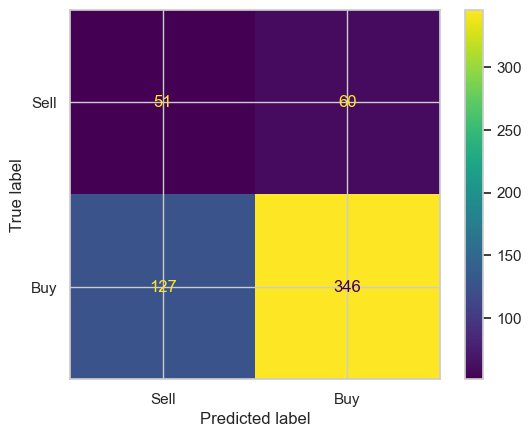

In [89]:
rfc_pipeline.fit(X_train, y_train)
y_pred = rfc_pipeline.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f1)
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)
ConfusionMatrixDisplay(cm, display_labels= ['Sell','Buy']).plot()

##### Hyper Parameter Tuning

In [90]:
rfc_params = {'random_forest__max_depth': [5,10,15,20,25], 'random_forest__n_estimators': [45,50,55,60,65]}

In [91]:
gs = GridSearchCV(rfc_pipeline, rfc_params, cv = 5, scoring = 'f1', verbose = 1)
gs.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=7)),
                                       ('random_forest',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'random_forest__max_depth': [5, 10, 15, 20, 25],
                         'random_forest__n_estimators': [45, 50, 55, 60, 65]},
             scoring='f1', verbose=1)

In [92]:
gs.best_params_

{'random_forest__max_depth': 25, 'random_forest__n_estimators': 65}

In [93]:
gs.best_score_

0.8023915981908365

Updating Parameters

In [122]:
rfc = RandomForestClassifier(max_depth = 20, n_estimators = 55, random_state = 42)
rfc_pipeline = Pipeline([('smote', smt),('scaler', ss),('random_forest', rfc)])

0.812227074235808


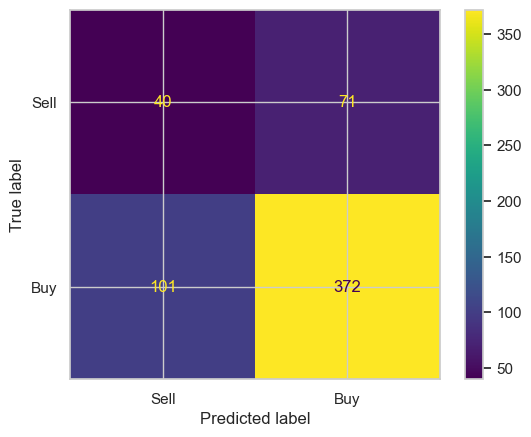

In [123]:
rfc_pipeline.fit(X_train, y_train)
y_pred = rfc_pipeline.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f1)
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)
ConfusionMatrixDisplay(cm, display_labels= ['Sell','Buy']).plot()

### Convolutional Neural Network

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

Preprocessing Data

In [97]:
# Preparing Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE
smt = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smt.fit_resample(X_train, y_train)

# PCA
pca = PCA(n_components = 5)
X_train_ready = pca.fit_transform(X_train_resampled)
X_test_ready = pca.transform(X_test_scaled)

# Reshaping Data
X_train_ready = X_train_resampled.values.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], 1)
X_test_ready = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Encode labels
y_train_encoded = to_categorical(y_train_resampled)
y_test_encoded = to_categorical(y_test)

c:\Users\cnade\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [98]:
# Creating F1 Score for Neural Network
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [99]:
# Creating Neural Network Function
def create_classification_model(dropout_rate=0.2, l2_weight=0.001, batch_size=32, epochs=10):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_ready.shape[1],1), kernel_regularizer=l2(l2_weight)))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(l2_weight)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(2, activation='softmax', kernel_regularizer=l2(l2_weight)))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_m])
    return model

In [100]:
model = create_classification_model()
model.fit(X_train_ready, y_train_encoded, epochs=25, validation_data=(X_test_ready, y_test_encoded))

Epoch 1/25
67/67 [==============================] - 1s 6ms/step - loss: 65494824.0000 - f1_m: 0.5993 - val_loss: 0.7932 - val_f1_m: 0.8174
Epoch 2/25
67/67 [==============================] - 0s 3ms/step - loss: 32382832.0000 - f1_m: 0.5900 - val_loss: 0.7919 - val_f1_m: 0.8158
Epoch 3/25
67/67 [==============================] - 0s 4ms/step - loss: 21618708.0000 - f1_m: 0.6101 - val_loss: 0.7923 - val_f1_m: 0.8174
Epoch 4/25
67/67 [==============================] - 0s 3ms/step - loss: 12760777.0000 - f1_m: 0.6101 - val_loss: 0.7898 - val_f1_m: 0.8174
Epoch 5/25
67/67 [==============================] - 0s 3ms/step - loss: 9155967.0000 - f1_m: 0.5872 - val_loss: 0.7896 - val_f1_m: 0.8174
Epoch 6/25
67/67 [==============================] - 0s 4ms/step - loss: 5860026.0000 - f1_m: 0.6101 - val_loss: 0.7903 - val_f1_m: 0.8174
Epoch 7/25
67/67 [==============================] - 0s 4ms/step - loss: 3581807.2500 - f1_m: 0.6152 - val_loss: 0.7859 - val_f1_m: 0.8174
Epoch 8/25
67/67 [============

##### These Models Stunk. Let's try something else...

## Regression Modeling for Expected Growth Rate

In [101]:
# Loading in Data
modeling_growth_df = stock_data[['Ticker', 'TotalRevenue', 'NormEBITDA', 'ReturnOnAssets','ChangeNormEBITDA','ChangeRevenue','OperatingCashFlow','ChangeOCF', 'ExpectedGrowthRate', 'Sector']]
modeling_growth_df.set_index('Ticker', inplace = True)

In [102]:
# Define X, y and train test split
X = modeling_growth_df.drop(['ExpectedGrowthRate', 'Sector'], axis = 1)
y = modeling_growth_df['ExpectedGrowthRate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state= 42)

### Linear Regression Baseline Model

In [103]:
linreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Fit pipeline to training data
linreg_pipeline.fit(X_train, y_train)

# Evaluate pipeline on testing data
y_pred = linreg_pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('Root mean squared error:', rmse)

Root mean squared error: 0.4021873021021452


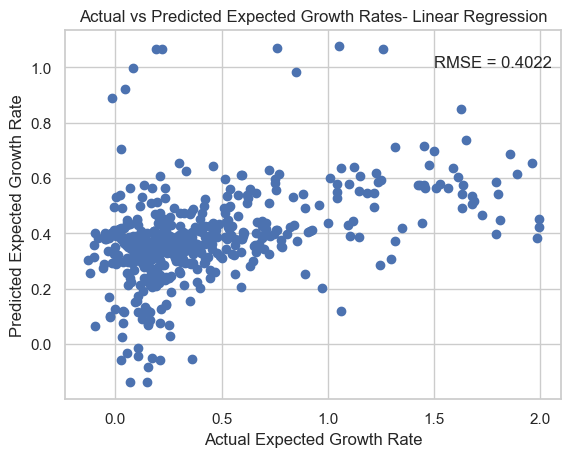

In [104]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Expected Growth Rate')
plt.ylabel('Predicted Expected Growth Rate')
plt.title('Actual vs Predicted Expected Growth Rates- Linear Regression')
plt.text(1.5,1, 'RMSE = 0.4022')
plt.show()

### Neural Network Part 2- A Feedforward Neural Network

In [105]:
# Preparing Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshaping Data
X_train_ready = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_ready = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

In [106]:
def create_continuous_model(dropout_rate=0.2, l2_weight=0.001, batch_size=32, epochs=10):
    model = Sequential()
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(l2_weight)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear', kernel_regularizer=l2(l2_weight)))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    return model

In [107]:
model = create_continuous_model()
model.fit(X_train_ready, y_train, epochs = 25, batch_size = 32, validation_data=[X_test_ready, y_test])

Epoch 1/25
46/46 [==============================] - 1s 6ms/step - loss: 0.3775 - mse: 0.3622 - val_loss: 0.1797 - val_mse: 0.1646
Epoch 2/25
46/46 [==============================] - 0s 3ms/step - loss: 0.1984 - mse: 0.1835 - val_loss: 0.1690 - val_mse: 0.1543
Epoch 3/25
46/46 [==============================] - 0s 3ms/step - loss: 0.1825 - mse: 0.1680 - val_loss: 0.1590 - val_mse: 0.1447
Epoch 4/25
46/46 [==============================] - 0s 3ms/step - loss: 0.1644 - mse: 0.1503 - val_loss: 0.1542 - val_mse: 0.1402
Epoch 5/25
46/46 [==============================] - 0s 3ms/step - loss: 0.1586 - mse: 0.1449 - val_loss: 0.1525 - val_mse: 0.1389
Epoch 6/25
46/46 [==============================] - 0s 3ms/step - loss: 0.1615 - mse: 0.1482 - val_loss: 0.1572 - val_mse: 0.1441
Epoch 7/25
46/46 [==============================] - 0s 3ms/step - loss: 0.1682 - mse: 0.1553 - val_loss: 0.1560 - val_mse: 0.1432
Epoch 8/25
46/46 [==============================] - 0s 3ms/step - loss: 0.1583 - mse: 0.14

#### Getting Test Predictions for Visualizations

In [108]:
y_pred = model.predict(X_test_ready)
y_pred = pd.Series(y_pred.flatten())

16/16 [==============================] - 0s 1ms/step


In [109]:
# Results
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('Root mean squared error:', rmse)

Root mean squared error: 0.37102465005072055


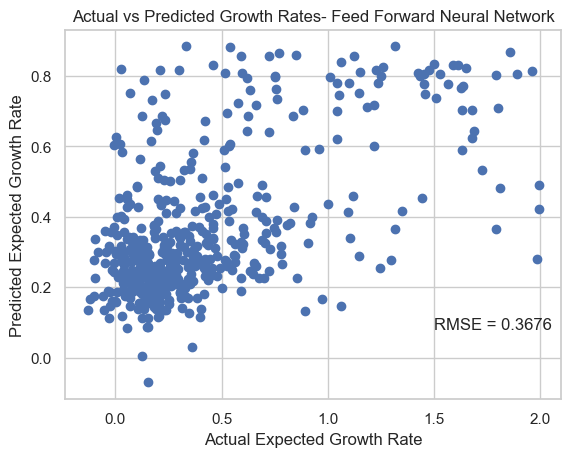

In [110]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Expected Growth Rate')
plt.ylabel('Predicted Expected Growth Rate')
plt.title('Actual vs Predicted Growth Rates- Feed Forward Neural Network')
#plt.legend(['RMSE: {:.4f}'.format(mse)])
plt.text(1.5,0.08, 'RMSE = 0.3676')
plt.show()

#### Breaking Down Sector Performance

In [111]:
# Labeling Y_Predictions to Merge
y_pred.name = 'ProjectedGrowthRate'
y_pred.index = y_test.index

In [112]:
sector_series = modeling_growth_df['Sector']
sector_series

Ticker
A               Healthcare
AA         Basic Materials
AAN            Industrials
AAOI            Technology
AAP      Consumer Cyclical
               ...        
ZS              Technology
ZTS             Healthcare
ZVIA    Consumer Defensive
ZWS            Industrials
ZYXI            Healthcare
Name: Sector, Length: 1945, dtype: object

In [113]:
# Merging Predictions with Actual Values, including sector
Merged_Predictions = pd.concat([y_test, y_pred], axis=1)

Merged_Predictions_With_Sector = Merged_Predictions.join(sector_series, how = 'inner')

In [114]:
Merged_Predictions_With_Sector.head()

,ExpectedGrowthRate,ProjectedGrowthRate,Sector
Ticker,,,
SPGI,0.164,0.216881,Financial Services
PRVB,0.029,0.819705,Healthcare
KEYS,0.212,0.137038,Technology
LTHM,0.480,0.232220,Basic Materials
CAKE,0.098,0.276264,Consumer Cyclical


### Calculating Residuals for Mean Absolute Error

In [115]:
Merged_Predictions_With_Sector['Residual Magnitude'] = np.absolute((Merged_Predictions_With_Sector['ExpectedGrowthRate'] - Merged_Predictions_With_Sector['ProjectedGrowthRate']))

Grouping by Sector, finding mean

In [116]:
averages_by_sector = Merged_Predictions_With_Sector.groupby('Sector')['Residual Magnitude'].mean().reset_index()
averages_by_sector

,Sector,Residual Magnitude
0,Basic Materials,0.165098
1,Communication Services,0.387631
2,Consumer Cyclical,0.175229
3,Consumer Defensive,0.199275
4,Energy,0.193552
5,Financial Services,0.163733
6,Healthcare,0.409527
7,Industrials,0.177094
8,Real Estate,0.130297
9,Technology,0.294197


Looks like our model is predicting Real Estate really well, while not doing as well with Healthcare and Communication Services companies performing the worst. Let's visualize this

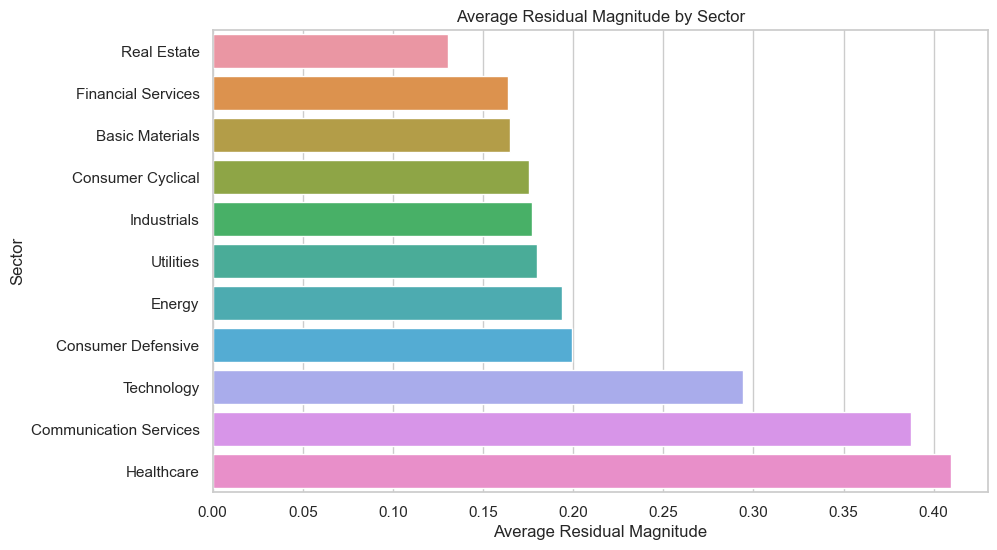

In [117]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='Residual Magnitude', y='Sector', data=averages_by_sector.sort_values('Residual Magnitude', ascending=True))
plt.title('Average Residual Magnitude by Sector')
plt.xlabel('Average Residual Magnitude')
plt.ylabel('Sector')
plt.show()